In [1]:
import json
import requests
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
df = pd.read_csv('../Data/dataset_desafio_2.csv')
df.head()

,MATRICULA,NOME,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,502375,Márcia Illiglener,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,397093,Jason Jytereoman Izoimum,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,915288,Bartolomeu Inácio da Gama,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,192652,Fernanda Guedes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,949491,Alessandre Borba Gomes,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


In [3]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        data = X.copy()
        return data.drop(labels=self.columns, axis='columns')

In [4]:
rm_columns = DropColumns(columns=["NOME","MATRICULA"])
rm_columns.fit(X=df)
df = pd.DataFrame.from_records(
    data=rm_columns.transform(
        X=df
    ),
)

In [5]:
df.head()

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


In [6]:
df['NOTA_GO'] = df.apply(
    lambda row: ((row['NOTA_MF']+row['NOTA_EM']+row['NOTA_DE'])/3) if np.isnan(row['NOTA_GO']) else row['NOTA_GO'],
    axis=1
)

In [7]:
si = SimpleImputer(
    missing_values=np.nan,  # os valores faltantes são do tipo ``np.nan`` (padrão Pandas)
    strategy='constant',  # a estratégia escolhida é a alteração do valor faltante por uma constante
    fill_value=0,  # a constante que será usada para preenchimento dos valores faltantes é um int64=0.
    verbose=0,
    copy=True
)

In [8]:
si.fit(X=df)

df = pd.DataFrame.from_records(
    data=si.transform(
        X=df
    ),  # o resultado SimpleImputer.transform(<<pandas dataframe>>) é lista de listas
    columns=df.columns  # as colunas originais devem ser conservadas nessa transformação
)

In [9]:
df.head()

,REPROVACOES_DE,REPROVACOES_EM,REPROVACOES_MF,REPROVACOES_GO,NOTA_DE,NOTA_EM,NOTA_MF,NOTA_GO,INGLES,H_AULA_PRES,TAREFAS_ONLINE,FALTAS,PERFIL
0,0,0,0,0,6.2,5.8,4.6,5.9,0.0,2,4,3,EXATAS
1,0,0,0,0,6.0,6.2,5.2,4.5,1.0,2,4,3,EXATAS
2,0,0,0,0,7.3,6.7,7.1,7.2,0.0,5,0,3,HUMANAS
3,1,3,1,1,0.0,0.0,0.0,0.0,1.0,4,4,4,DIFICULDADE
4,1,3,1,1,0.0,0.0,0.0,0.0,1.0,5,2,5,DIFICULDADE


In [10]:
df['REPROVACOES_H'] = df['REPROVACOES_DE'] + df['REPROVACOES_EM']
df['REPROVACOES_E'] = df['REPROVACOES_MF'] + df['REPROVACOES_GO']
df['MEDIA_H'] = (df['NOTA_DE']+df['NOTA_EM'])/2
df['MEDIA_E'] = (df['NOTA_MF']+df['NOTA_GO'])/2

In [11]:
features = [
    'REPROVACOES_DE', 'REPROVACOES_EM', 
    "REPROVACOES_MF", 
    "REPROVACOES_GO",
    "NOTA_DE", "NOTA_EM", 
    "NOTA_MF", 
    "NOTA_GO",
    "H_AULA_PRES", "TAREFAS_ONLINE", 
    "FALTAS", 
    # "REPROVACOES_H",
    # "REPROVACOES_E",
    # "MEDIA_H",
    # "MEDIA_E",
]

target = ["PERFIL"]

X = df[features]
y = df[target]

In [12]:
scaler = StandardScaler()
scaler.fit(df[features])
X_scaled = scaler.transform(df[features])
X_scaled

array([[-0.39485254, -0.39485254, -0.4424075 , ..., -0.75345062,
         0.46348442, -0.6333179 ],
       [-0.39485254, -0.39485254, -0.4424075 , ..., -0.75345062,
         0.46348442, -0.6333179 ],
       [-0.39485254, -0.39485254, -0.4424075 , ..., -0.02499806,
        -1.69300934, -0.6333179 ],
       ...,
       [-0.39485254, -0.39485254, -0.4424075 , ...,  0.70345449,
        -0.07563902, -1.82758133],
       [-0.39485254, -0.39485254,  1.04392711, ..., -0.5106331 ,
        -0.61476246,  1.15807725],
       [-0.39485254, -0.39485254,  1.04392711, ..., -0.5106331 ,
        -1.69300934,  1.15807725]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=337)

In [14]:
# classes_dict  = {
#     'DIFICULDADE': 8000, 
#     'EXATAS': 8000, 
#     'EXCELENTE': 8000, 
#     'HUMANAS': 8000, 
#     'MUITO_BOM': 8000
# }

# steps = [('o', SMOTE(sampling_strategy=classes_dict))]
# pipeline = Pipeline(steps=steps)

# X, y = pipeline.fit_resample(X_train, y_train)

In [15]:
clf = xgb.XGBClassifier(n_estimators=250, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score
print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 4)))

Acurácia: 79.67999999999999%


In [17]:
from sklearn.metrics import confusion_matrix
labels = ['DIFICULDADE', 'EXATAS', 'EXCELENTE', 'HUMANAS','MUITO_BOM']
cf_matrix=confusion_matrix(y_test, y_pred, labels)
print(cf_matrix)

[[1066  307    0   29    0]
 [ 167 1456    0    5    1]
 [   0    2   85   33   25]
 [   9    5   25  555   45]
 [   1   45   25   89   25]]


<AxesSubplot:>

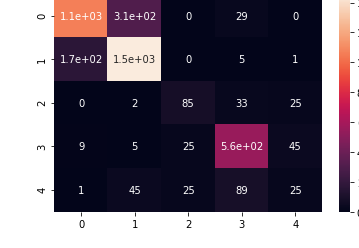

In [18]:
# plt.figure(figsize=(30,20))
sns.heatmap(cf_matrix, annot=True)